# Lecture 4: Preprocessing and `sklearn` pipelines

MTU Spring 2025

Instructor: Amna Mazen

### Announcements
- Homework 2 is out. Please start early (make sure to submit it on time).


## Imports

In [22]:
import sys
import time

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")


from IPython.display import display
#from plotting_functions import *

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#from utils import *

pd.set_option("display.max_colwidth", 200)

## Feature Scaling

### Bringing features onto the same scale

- Various different features can differ by orders of magnitude, where large values can domain smaller values.
- The majority of ML methods performs better if features are on the same scale.
- Common strategies to apply feature scaling:
    1. Normalization: rescaling feature to a range of [0, 1]
    2. Standardization: centering the feature columns at mean with standard deviation 1 so that it forms a standard normal distribution.


In [23]:
## Normalization example

from sklearn.preprocessing import MinMaxScaler
import numpy as np

X=np.array([[1,2],[3,4],[12,8],[10,9],[15,2],[5,1]])

mms=MinMaxScaler()
X_norm=mms.fit_transform(X)

print("Before scaling:\n", X)
print("\n")
print("After scaling:\n", X_norm)

Before scaling:
 [[ 1  2]
 [ 3  4]
 [12  8]
 [10  9]
 [15  2]
 [ 5  1]]


After scaling:
 [[0.         0.125     ]
 [0.14285714 0.375     ]
 [0.78571429 0.875     ]
 [0.64285714 1.        ]
 [1.         0.125     ]
 [0.28571429 0.        ]]


In [24]:
# Check standard deviation before standardization
np.std(X)

4.4907311951024935

In [25]:
from sklearn.preprocessing import StandardScaler
stdsc=StandardScaler()
X_std=stdsc.fit_transform(X)
print("Before standardization:\n", X)
print("\n")
print("After standardization:\n", X_std)

Before standardization:
 [[ 1  2]
 [ 3  4]
 [12  8]
 [10  9]
 [15  2]
 [ 5  1]]


After standardization:
 [[-1.32744662 -0.75482941]
 [-0.92921264 -0.10783277]
 [ 0.86284031  1.18616051]
 [ 0.46460632  1.50965882]
 [ 1.46019129 -0.75482941]
 [-0.53097865 -1.07832773]]


In [26]:
# Check standard deviation after standardization
np.std(X_std)

1.0

## Feature Selection
- Select a subset of the original features.
- Scikit-learn provide a variate of different [feature selection methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).



In [27]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X, y = load_iris(return_X_y=True)
print(X.shape)
print(X[0,:])

(150, 4)
[5.1 3.5 1.4 0.2]


In [28]:
X_new=SelectKBest(chi2, k=2).fit_transform(X,y)
print(X_new.shape)
print(X_new[0,:])

(150, 2)
[1.4 0.2]


In [29]:
data= load_iris(return_X_y=False)
df = pd.DataFrame(data=data.data, columns=data.feature_names)


In [30]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### Feature Importance sorting

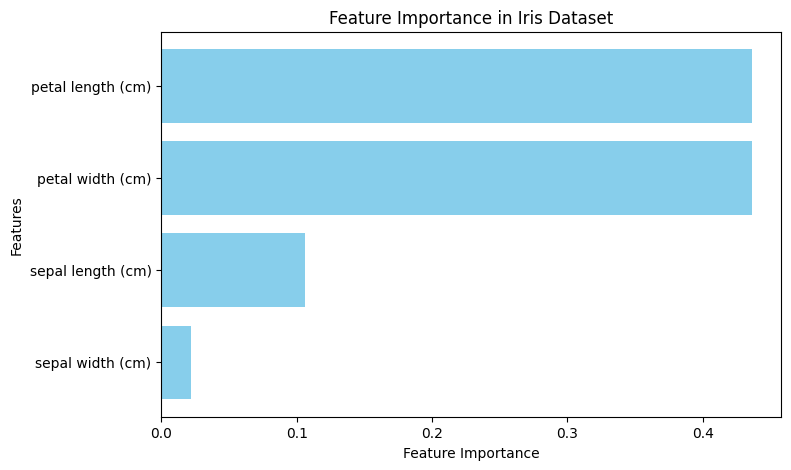

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances and sort them
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(np.array(iris.feature_names)[sorted_indices], feature_importances[sorted_indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Iris Dataset")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


### Correlation map

In [32]:
!pip install seaborn

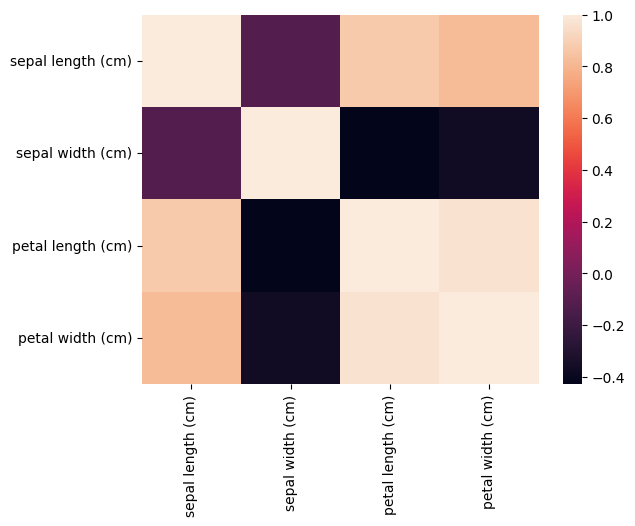

In [33]:
import seaborn as sns

sns.heatmap(df.corr());


### What all transformations we need to apply on the dataset?

Here is what we see from the EDA.

- Some missing values in `total_bedrooms` column
- Scales are quite different across columns.
- Categorical variable `ocean_proximity`

Read about [preprocessing techniques implemented in `scikit-learn`](https://scikit-learn.org/stable/modules/preprocessing.html).  

### Dataset, splitting, and baseline

We'll be working on [California housing prices regression dataset](https://raw.githubusercontent.com/MazenMTULab/ML_COURSE_RESOURCES/refs/heads/main/Dataset/Lecture_Dataset/housing.csv) to demonstrate these feature transformation techniques. The task is to predict median house values in Californian districts, given a number of features from these districts. If you are running the notebook on your own, you'll have to download the data and put it in the data directory.

In [57]:
housing_df = pd.read_csv("https://raw.githubusercontent.com/MazenMTULab/ML_COURSE_RESOURCES/refs/heads/main/Dataset/Lecture_Dataset/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1)

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8001,-118.13,33.85,36.0,1885.0,391.0,1049.0,405.0,3.5500,212800.0,<1H OCEAN
18146,-122.03,37.35,16.0,1156.0,198.0,455.0,216.0,7.2779,292900.0,<1H OCEAN
8206,-118.16,33.79,25.0,3742.0,1180.0,3916.0,1063.0,2.4000,153700.0,NEAR OCEAN
11873,-117.37,34.00,36.0,730.0,155.0,476.0,142.0,2.4306,88900.0,INLAND
13174,-121.06,36.72,23.0,395.0,70.0,166.0,52.0,2.2132,100000.0,INLAND


In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18576 entries, 8001 to 10210
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18576 non-null  float64
 1   latitude            18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         18576 non-null  float64
 4   total_bedrooms      18390 non-null  float64
 5   population          18576 non-null  float64
 6   households          18576 non-null  float64
 7   median_income       18576 non-null  float64
 8   median_house_value  18576 non-null  float64
 9   ocean_proximity     18576 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We have one categorical feature and all other features are numeric features.

In [59]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18576.000000,18576.000000,18576.000000,18576.000000,18390.000000,18576.000000,18576.000000,18576.000000,18576.000000
mean,-119.567527,35.628944,28.605674,2641.080911,538.570201,1426.871339,500.445844,3.873261,206917.246770
std,2.002404,2.134899,12.595580,2195.134035,422.730624,1138.655240,384.183983,1.901097,115554.537628
min,-124.350000,32.540000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1451.000000,296.250000,788.000000,280.000000,2.562500,119400.000000
50%,-118.500000,34.260000,29.000000,2127.000000,435.000000,1166.000000,410.000000,3.534600,179600.000000
75%,-118.000000,37.710000,37.000000,3155.000000,647.000000,1726.000000,606.000000,4.747275,264925.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Notes**
- Seems like total_bedrooms column has some missing values.
- The feature scales are quite different.

In [60]:
housing_df["total_bedrooms"].isnull().sum()

207

#### Histogram

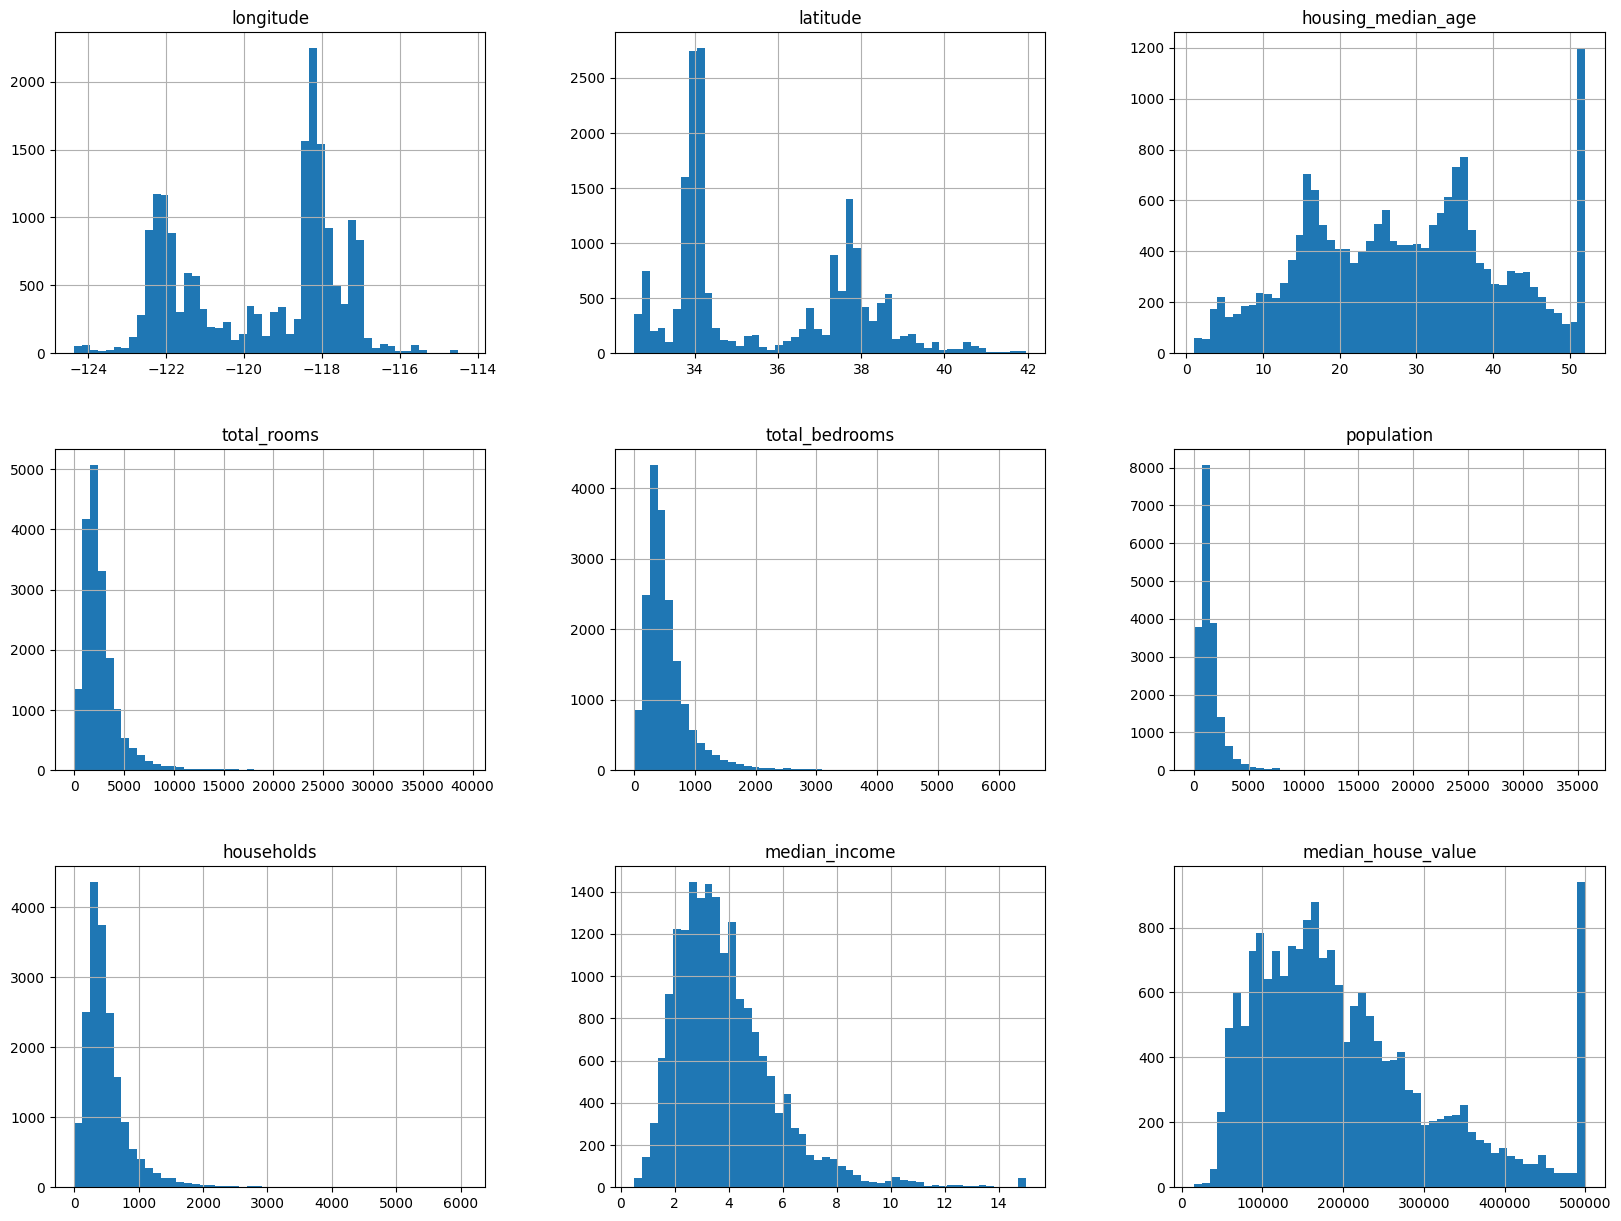

In [61]:

train_df.hist(bins=50, figsize=(20, 15));


In [75]:
X_train = train_df.drop(columns=["median_house_value"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value"])
y_test = test_df["median_house_value"]

#### How many samples for every category

In [76]:
X_train["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,8221
INLAND,5891
NEAR OCEAN,2412
NEAR BAY,2047
ISLAND,5


## Pipeline and Column Transformer in `sklearn` on the California housing dataset

In [77]:
housing_df = pd.read_csv("https://raw.githubusercontent.com/MazenMTULab/ML_COURSE_RESOURCES/refs/heads/main/Dataset/Lecture_Dataset/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN


In [78]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [79]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,167600.0,<1H OCEAN,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,180900.0,<1H OCEAN,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,286200.0,<1H OCEAN,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY,4.739264,1.024540,1.720859


In [80]:
# Let's keep both numeric and categorical columns in the data.
X_train = train_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_test = test_df["median_house_value"]

In [81]:
from sklearn.compose import ColumnTransformer, make_column_transformer


In [82]:
X_train.head(10)


,longitude,latitude,housing_median_age,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,NEAR OCEAN,3.817558,1.004801,4.323045
9730,-121.74,36.79,16.0,611.0,4.3814,<1H OCEAN,6.286416,1.014730,2.944354
14690,-117.09,32.80,36.0,360.0,4.7188,NEAR OCEAN,6.008333,1.019444,2.541667
7938,-118.11,33.86,33.0,393.0,5.3889,<1H OCEAN,6.078880,1.043257,3.127226
18365,-122.12,37.28,21.0,56.0,5.8691,<1H OCEAN,6.232143,1.142857,2.660714
10931,-117.91,33.74,25.0,922.0,2.9926,<1H OCEAN,4.634490,1.046638,3.195228


In [83]:
X_train.columns


Index(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_household', 'population_per_household'],
      dtype='object')

In [84]:
# Identify the categorical and numeric columns
numeric_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_household",
    "population_per_household",
]

categorical_features = ["ocean_proximity"]
target = "median_income"

- Let's create a ColumnTransformer for our dataset.


In [85]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18576 entries, 6051 to 19966
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   households                18576 non-null  float64
 4   median_income             18576 non-null  float64
 5   ocean_proximity           18576 non-null  object 
 6   rooms_per_household       18576 non-null  float64
 7   bedrooms_per_household    18391 non-null  float64
 8   population_per_household  18576 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


In [86]:
X_train["ocean_proximity"].value_counts()


,count
ocean_proximity,
<1H OCEAN,8221
INLAND,5915
NEAR OCEAN,2389
NEAR BAY,2046
ISLAND,5


In [87]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [88]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [89]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
)

In [90]:
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'households', 'median_income',
                                  'rooms_per_household',
                                  'bedrooms_per_household',
                                  'population_per_household']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['ocean_proximity'])])

In [91]:
X_train_pp = preprocessor.fit_transform(X_train)


In [92]:
preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
    categorical_features
)

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [93]:
column_names = numeric_features + list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_features
    )
)
column_names

['longitude',
 'latitude',
 'housing_median_age',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_household',
 'population_per_household',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [94]:
pd.DataFrame(X_train_pp, columns=column_names)


,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.908140,-0.743917,-0.526078,0.266135,-0.389736,-0.210591,-0.083813,0.126398,0.0,1.0,0.0,0.0,0.0
1,-0.002057,1.083123,-0.923283,-1.253312,-0.198924,4.726412,11.166631,-0.050132,0.0,1.0,0.0,0.0,0.0
2,1.218207,-1.352930,1.380504,0.542873,-0.635239,-0.273606,-0.025391,-0.099240,0.0,0.0,0.0,0.0,1.0
3,1.128188,-0.753286,-0.843842,-0.561467,0.714077,0.122307,-0.280310,0.010183,0.0,1.0,0.0,0.0,0.0
4,1.168196,-1.287344,-0.843842,2.500924,-1.059242,-0.640266,-0.190617,0.126808,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18571,0.733102,-0.804818,0.586095,-0.966131,-0.118182,0.063110,-0.099558,0.071541,1.0,0.0,0.0,0.0,0.0
18572,1.163195,-1.057793,-1.161606,0.728235,0.357500,0.235096,-0.163397,0.007458,1.0,0.0,0.0,0.0,0.0
18573,-1.097293,0.797355,-1.876574,0.514155,0.934269,0.211892,-0.135305,0.044029,1.0,0.0,0.0,0.0,0.0
18574,-1.437367,1.008167,1.221622,-0.454427,0.006578,-0.273382,-0.149822,-0.132875,0.0,0.0,0.0,1.0,0.0


In [95]:
knn_pipe = make_pipeline(preprocessor, KNeighborsRegressor())


In [96]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'bedrooms_per_household',
                                                   'population_per_household']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [97]:
knn_pipe.score(X_train, y_train)

0.8059396097446094

In [98]:
knn_pipe.score(X_test, y_test)

0.7264637019551918

## Pipeline in `sklearn` on the California housing dataset

In this technique you are responsible for handling the OneHotEncoding for categorical features before the pipeline

#### Onehot Encoding for "ocean_proximity" feature in **training** Dataframe

In [72]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder (use sparse_output instead of sparse)
ohe = OneHotEncoder(sparse_output=False, dtype=int)  # Updated parameter

# Fit and transform the column
X_imp_ohe_train = ohe.fit_transform(X_train[["ocean_proximity"]])

# Get feature names from the encoder
encoded_feature_names = ohe.get_feature_names_out(["ocean_proximity"])

# Ensure the shape matches when creating the DataFrame
encoded_df = pd.DataFrame(X_imp_ohe_train, columns=encoded_feature_names, index=X_train.index)

# Replace the original column with encoded features
X_train = X_train.drop(columns=["ocean_proximity"])
X_train = pd.concat([X_train, encoded_df], axis=1)

# Print the result
print(X_train.head())


       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
8001     -118.13     33.85                36.0       1885.0           391.0   
18146    -122.03     37.35                16.0       1156.0           198.0   
8206     -118.16     33.79                25.0       3742.0          1180.0   
11873    -117.37     34.00                36.0        730.0           155.0   
13174    -121.06     36.72                23.0        395.0            70.0   

       population  households  median_income  ocean_proximity_<1H OCEAN  \
8001       1049.0       405.0         3.5500                          1   
18146       455.0       216.0         7.2779                          1   
8206       3916.0      1063.0         2.4000                          0   
11873       476.0       142.0         2.4306                          0   
13174       166.0        52.0         2.2132                          0   

       ocean_proximity_INLAND  ocean_proximity_ISLAND  \
8001             

In [65]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor())

In [66]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [67]:
pipe.score(X_train, y_train)

0.819139735565528